## Predicting sales from historical data

Given daily sales data for a 2.5 year period across different stores, predict future daily sales at each store, with the evaluation metric being root-mean-square percent error ($ \mathit{RMSPE}$). For each entry, information is provided regarding the store's size and type, its nearest competitors, whether they ran a promotion, and whether the day was a holiday.

***

## Analysis

#### Edvin Memet (edvinmemet@fas.harvard.edu)

As we are asked to optimise $\mathit{RMSPE}$, we can simply log-transform the sales data and optimize $\mathit{RMSE}$:

$$ \mathit{RMSPE} \sim \sum \left(\frac{y-\hat y}{y}\right)^2$$ 

$$ \mathit{RMSE} \left[ \mathrm{log }\right] \sim \sum \left(\log{y}-\log{\hat y}\right)^2 \sim \sum \left(\log{\frac{\hat y}{ y}}\right)^2 \sim \sum \left[\log \left(1 + \frac{\hat y-y}{ y} \right)\right]^2 \approx \sum \left(\frac{\hat y-y}{ y}\right)^2 $$,

where in the last step we use $\log\left(1+x\right) \approx x$ for $ x \ll 1$. 

After exploring the data and removing outliers and incorrect data (e.g. there are 18 instances in which `sls = 0` when the store is marked as open; there are also instances of negative sales `sls<0`), we split the data into training and validation sets. The data spans a 2.5 year period (Jan 1 2013 - Jun 10 2015) and our goal is to predict data for June and July 2015. Consequently, we choose a splitting point of Jun 1 2014, so that our validation set includes the months of June and July, which are present in the test dataset.

1. We start the analysis with a baseline model that only takes into account day, week, and year information. We train four different models `Linear Regression`, `Random Forest`, `CatBoost`, and `LightGBM`.


2. We can easily improve on the baseline by taking into account there are > 500 different stores, with different average sales (e.g. due to location, competition, prices). Rather than one-hot encode >500 store IDs, we can use mean-label encoding. In this case we shouldn't need to smooth a store's mean sales by the global average, since we have almost 1000 data points for each store.


3. Next we include all available features, which achieves $\mathit{RMSPE} \approx 0.16$ with the Random Forest model. When we examine feature importance (through the permutation method) in both the `LightGBM` and `Random Forest` models, we find that they are not perfectly consistent. To get a more accurate notion of feature importance, we use the `shap` package, which calculates feature importance based on Shapley values, shown to be more consistent than other methods (https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27).


4. After getting a notion of feature importance, we include interaction terms between the most important features. This slightly improves the prediction.


5. Next, we can include features that represent the sales at the given store some time in the past. For our purposes, since our goal is to predict sales for a 8-week period, it probably would not be advisable to look 1-week in the past (e.g. errors on the test set would compound). Instead we look back 8 weeks, 2 months, and 1 year, which marginally improves the $\mathit{RMSPE}$, with the best model being `LightGBM`. 


6. Finally, we perform hyperparameter tuning for the `LightGBM` model using `GridSearchCV` and a 3-fold `TimeSeriesSplit` of the data for cross-validation, which leads to $\mathit{RMSPE} \approx 0.15$ on the validation data. 

In [1]:
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from catboost import *
import lightgbm as lgb
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
shap.initjs()

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 
            'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def print_scores(reg, x_tr, y_tr, x_val, y_val, model):
    r2 = reg.score(x_tr, y_tr)
    rmspe_train = np.sqrt(mean_squared_error(reg.predict(x_tr), y_tr.values))
    rmspe_val = np.sqrt(mean_squared_error(reg.predict(x_val), y_val.values))
    print(model + ': R^2 = ' + str(round(r2,3)) + ', ' + 'RMSPE = ' + 
          str(round(rmspe_train,3)) + ', ' + 'RMSPE validation = ' + 
          str(round(rmspe_val,3)))   
    
def rmspe(x,y): 
    x = x[y>0]
    y = y[y>0]
    return np.sqrt((((x-y)**2)/y**2).mean())

def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/edvinmemet/projects/master/data/sales_forecasting/challenge_train.csv?token=AF52KYN2A3P3S26DXAXMAGS5WIGLY")
df_store = pd.read_csv("https://raw.githubusercontent.com/edvinmemet/projects/master/data/sales_forecasting/challenge_store.csv?token=AF52KYJBFVPO2D7U6HWZK525WINVO")
df = pd.merge(df, df_store, how='left')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by = ['date'], ascending = False)
df.head()

,id,day,date,sls,cus,open,promo,statehol,schoolhol,type,assortment,comp_distance,comp_open_month,comp_open_yr
0,1,3,2015-06-10,3591.0,453,1,0,0,0,c,a,1270.0,9.0,2008.0
374,759,3,2015-06-10,6306.0,715,1,0,0,0,a,a,110.0,11.0,2012.0
368,751,3,2015-06-10,3353.0,548,1,0,0,0,a,a,650.0,10.0,2006.0
369,753,3,2015-06-10,6952.0,671,1,0,0,0,d,c,540.0,11.0,2012.0
370,754,3,2015-06-10,5947.0,759,1,0,0,0,c,c,380.0,5.0,2008.0


Use the `comp_open_month` and `comp_open_yr` to create a new binary feature encoding whether the competition store is already open or not, `comp_isopen`.

In [3]:
na_map = {'comp_open_yr': 2000, 'comp_open_month': 1}
df = df.fillna(na_map)
df['comp_isopen'] = ''
comp_isopen=[]
for ix in df.index:
    if(datetime.date(year = df.loc[ix, 'comp_open_yr'].astype(int), month = df.loc[ix, 'comp_open_month'].astype(int), day = 15) > df.loc[ix, 'date']):
        comp_isopen.append(0)
    else:
        comp_isopen.append(1)
df['comp_isopen'] = comp_isopen
df = df.drop(['comp_open_month', 'comp_open_yr'], axis=1)
df.head()

,id,day,date,sls,cus,open,promo,statehol,schoolhol,type,assortment,comp_distance,comp_isopen
0,1,3,2015-06-10,3591.0,453,1,0,0,0,c,a,1270.0,1
374,759,3,2015-06-10,6306.0,715,1,0,0,0,a,a,110.0,1
368,751,3,2015-06-10,3353.0,548,1,0,0,0,a,a,650.0,1
369,753,3,2015-06-10,6952.0,671,1,0,0,0,d,c,540.0,1
370,754,3,2015-06-10,5947.0,759,1,0,0,0,c,c,380.0,1


Look for missing values; impute by the median. Add new datetime-based features: `Week`, `Month`, etc. Examine feature distributions to check for outliers. 

In [4]:
df.isnull().sum().sort_index()/len(df) #only comp_distance has missing values
df['comp_distance'] = df['comp_distance'].fillna(df['comp_distance'].median())
add_datepart(df, 'date', drop = False) #add various date features
for col in ['Dayofweek', 'Month', 'Year', 'Week', 'Day', 'Dayofyear']:
    df[col] = df[col].apply(lambda x:str(x))
df.describe()

,id,day,sls,cus,open,promo,schoolhol,comp_distance,comp_isopen,Elapsed
count,479727.000000,479727.00000,479727.000000,479727.000000,479727.000000,479727.000000,479727.000000,479727.000000,479727.000000,4.797270e+05
mean,565.674759,3.99708,5685.016488,622.082855,0.827856,0.380883,0.175771,5467.842273,0.909130,1.394872e+09
std,325.005106,1.99927,3906.265275,457.142240,0.377506,0.485604,0.380625,7512.841569,0.287425,2.236739e+07
min,1.000000,1.00000,-1547.000000,-179.000000,0.000000,0.000000,0.000000,40.000000,0.000000,1.356998e+09
25%,273.000000,2.00000,3611.000000,393.000000,1.000000,0.000000,0.000000,780.000000,1.000000,1.375574e+09
50%,578.000000,4.00000,5665.000000,603.000000,1.000000,0.000000,0.000000,2380.000000,1.000000,1.394150e+09
75%,849.000000,6.00000,7763.000000,831.000000,1.000000,1.000000,0.000000,6540.000000,1.000000,1.414454e+09
max,1115.000000,7.00000,388504.245600,7388.000000,1.000000,1.000000,1.000000,48330.000000,1.000000,1.433894e+09


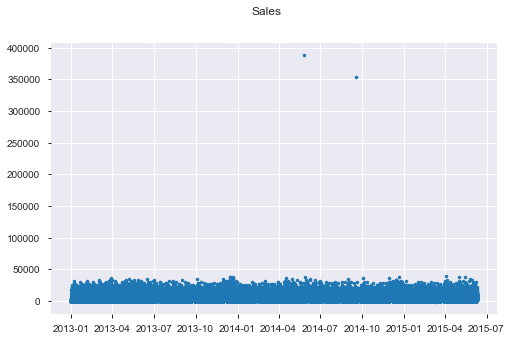

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(df.date, df.sls, '.');
plt.suptitle('Sales');

Remove outliers and other instances of incorrect data.

In [6]:
df = df[(df.sls<100000) & (df.sls >=0)] #remove outliers and negative values (but not zero)
df = df[~((df.sls == 0) & (df.open == 1))] #remove instances where the store was open but reported zero sales
df = df[~((df.date=='2014-11-22') & (df.sls < 50))] #remove outlier near Christmas

Plot average sales aggregated by day/month/year.

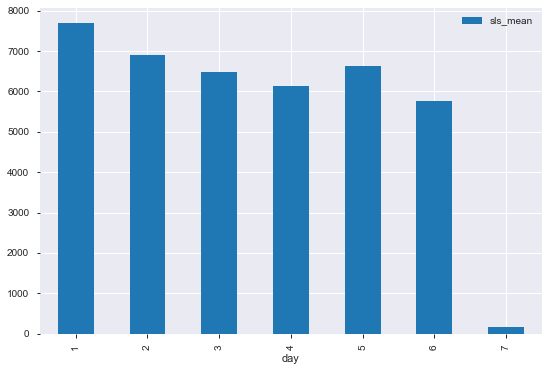

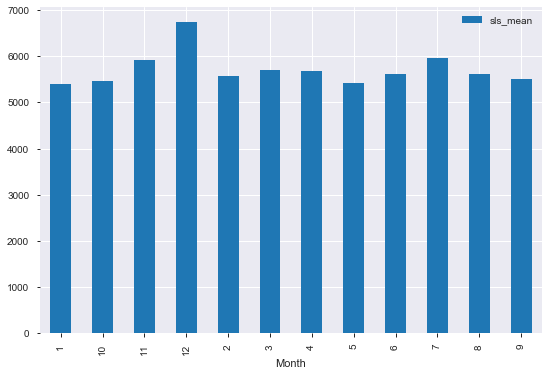

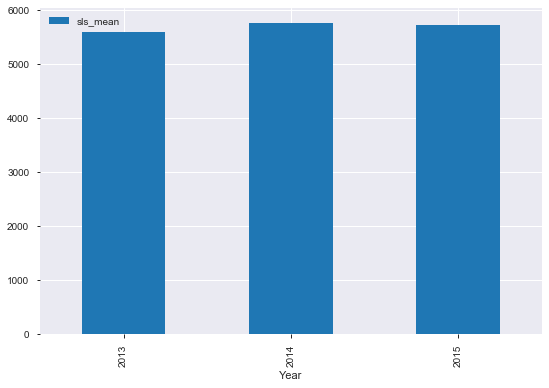

In [7]:
df.groupby('day').agg(sls_mean = ('sls', 'mean')).plot.bar(figsize = (9,6))
df.groupby('Month').agg(sls_mean = ('sls', 'mean')).plot.bar(figsize = (9,6))
df.groupby('Year').agg(sls_mean = ('sls', 'mean')).plot.bar(figsize = (9,6))

Plot weekly, monthly, and yearly average sales.

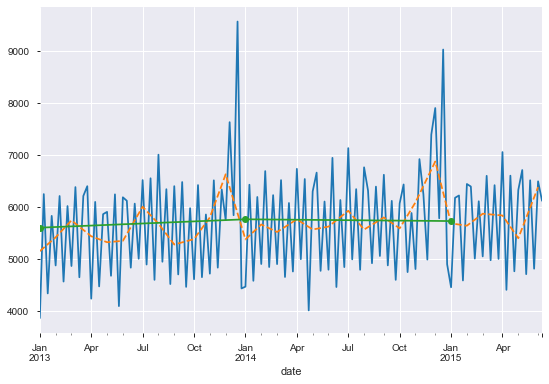

In [8]:
fig, ax = plt.subplots(figsize=(9,6))
df.set_index('date')['sls'].resample('W').mean().plot(style = '-')
df.set_index('date')['sls'].resample('M').mean().plot(style = '--')
df.set_index('date')['sls'].resample('Y').mean().plot(style = 'o-');

Log-transform the target variable (sales) so that the $\mathit{RMSE}$ of the tranformed data is approximately equal to the $\mathit{RMSPE}$ of the original data. Split the data into training (1.5 years) and validation  sets (1 year). 

In [9]:
df['sls'] = np.log1p(df['sls'])

date_cutoff = '2014-06-01 00:00:00'
df_val, df_tr = split_vals(df, sum(df.date > date_cutoff))

y_tr, y_val = df_tr['sls'], df_val['sls']

## Baseline model

As a first model, we only include the `Year`, `Month`, and `Dayofweek` features. Of the four models trained, (`Linear Regression`, `Random Forest`, `CatBoost`, and `LightGBM`) Linear Regression does best, which makes sense, since all the features in the baseline model are categorical and become binary after one-hot encoding. Thus, there are no complicated splits that would allow decision tree models to outperform linear regression. 

In [10]:
x0_tr = df_tr[['Dayofweek', 'Year', 'Month']]
x0_val = df_val[['Dayofweek', 'Year', 'Month']]
cat=CatBoostRegressor(n_estimators=200, one_hot_max_size = 100, loss_function='RMSE', silent=True)

cat.fit(x0_tr, y_tr, cat_features=x0_tr.select_dtypes('object').columns, eval_set=(x0_val, y_val))
print_scores(cat, x0_tr, y_tr, x0_val, y_val, 'CatBoost')

CatBoost: R^2 = 0.787, RMSPE = 1.531, RMSPE validation = 1.74


In [11]:
x0_tr, x0_val = pd.get_dummies(x0_tr), pd.get_dummies(x0_val)

reg = linear_model.LinearRegression()
rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=7, n_jobs=-1)
lgbm = lgb.LGBMRegressor(n_estimators=200, eval_metric = 'rmse')

reg.fit(x0_tr, y_tr)
print_scores(reg, x0_tr, y_tr, x0_val, y_val, 'Reg')

rf.fit(x0_tr, y_tr)
print_scores(rf, x0_tr, y_tr, x0_val, y_val, 'RF')

lgbm.fit(x0_tr, y_tr, eval_set=(x0_val, y_val), early_stopping_rounds=20, verbose=False)
print_scores(lgbm, x0_tr, y_tr, x0_val, y_val, 'LGBM')

Reg: R^2 = 0.757, RMSPE = 1.635, RMSPE validation = 1.698
RF: R^2 = 0.791, RMSPE = 1.517, RMSPE validation = 1.735
LGBM: R^2 = 0.789, RMSPE = 1.524, RMSPE validation = 1.725


## Model 1: mean-target encoding by store id

As a first improvement to the baseline, we can include information about each individual store, since they have different average sales depending on location, competitors, etc. Since there are >500 different stores, rather than one-hot encode the id feature, we can use mean-target encoding, i.e. create a column containing the mean sales for each store id. This yields a small improvement to the baseline, with LightGBM achieving the best score. Note that we don't really need to smoothe the encoded means, since each store has $\sim1000$ data points such that the average sales figure for any given store is not very noisy.

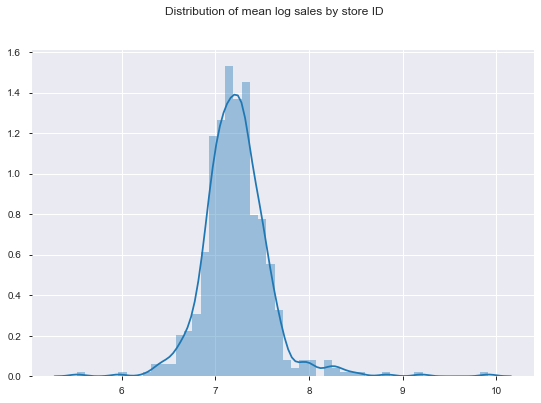

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
sns.distplot(df_tr.groupby('id').agg(sls_by_id = ('sls', 'mean')))
plt.suptitle('Distribution of mean log sales by store ID');

In [13]:
df1_tr = df_tr[['id', 'Dayofweek', 'Year', 'Month', 'sls']].set_index('id')
df1_tr = pd.merge(df1_tr, df1_tr.groupby('id').agg(sls_by_id = ('sls', 'mean')), on='id', how = 'left')
df1_val = df_val[['id', 'Dayofweek', 'Year', 'Month', 'sls']].set_index('id')
df1_val = pd.merge(df1_val, df1_tr.groupby('id').agg(sls_by_id = ('sls', 'mean')), on='id', how = 'left')

x1_tr, x1_val = df1_tr.drop(['sls'], axis=1), df1_val.drop(['sls'], axis=1)

In [14]:
cat.fit(x1_tr, y_tr, cat_features=df1_tr.select_dtypes('object').columns, eval_set=(x1_val, y_val))
print_scores(cat, x1_tr, y_tr, x1_val, y_val, 'CatBoost')

CatBoost: R^2 = 0.808, RMSPE = 1.453, RMSPE validation = 1.634


In [15]:
x1_tr, x1_val = pd.get_dummies(x1_tr, drop_first=True), pd.get_dummies(x1_val, drop_first=True)

reg.fit(x1_tr, y_tr)
print_scores(reg, x1_tr, y_tr, x1_val, y_val, 'Reg')

rf.fit(x1_tr, y_tr)
print_scores(rf, x1_tr, y_tr, x1_val, y_val, 'RF')

lgbm.fit(x1_tr, y_tr, eval_set=(x1_val, y_val), early_stopping_rounds=20, verbose=False)
print_scores(lgbm, x1_tr, y_tr, x1_val, y_val, 'LGBM')

Reg: R^2 = 0.769, RMSPE = 1.595, RMSPE validation = 1.667
RF: R^2 = 0.83, RMSPE = 1.365, RMSPE validation = 1.65
LGBM: R^2 = 0.811, RMSPE = 1.441, RMSPE validation = 1.629


## Model 2: all features

Including the rest of the features improves model performance substantially, giving us $ \mathrm{RMPSE} \approx 0.16$. We examine feature importance using both the permuted features method (less reliable) and the Shapley value method (more reliable). Overall, the most important features are `open`, `sls_by_id`, `promo`, and `Dayofweek`. In particular, `open` is by far the most important feature. Clearly, not knowing whether a store is open or not is what was causing the large $ \mathrm{RMPSE}$ scores reported by earlier models.

In [16]:
df2_tr = df_tr.drop(['date', 'day', 'cus', 'Elapsed', 'Dayofyear', 'Day'], axis = 1).set_index('id')
df2_tr = pd.merge(df2_tr, df2_tr.groupby('id').agg(sls_by_id = ('sls', 'mean')), on='id', how = 'left')
df2_val = df_val.drop(['date', 'day', 'cus', 'Elapsed', 'Dayofyear', 'Day'], axis = 1).set_index('id')
df2_val = pd.merge(df2_val, df2_tr.groupby('id').agg(sls_by_id = ('sls', 'mean')), on='id', how = 'left')

x2_tr, x2_val = df2_tr.drop(['sls'], axis=1), df2_val.drop(['sls'], axis=1)

cat.fit(x2_tr, y_tr, cat_features=df2_tr.select_dtypes(include = ['object', 'bool']).columns, eval_set=(x2_val, y_val))
print_scores(cat, x2_tr, y_tr, x2_val, y_val, 'CatBoost')

CatBoost: R^2 = 0.997, RMSPE = 0.19, RMSPE validation = 0.201


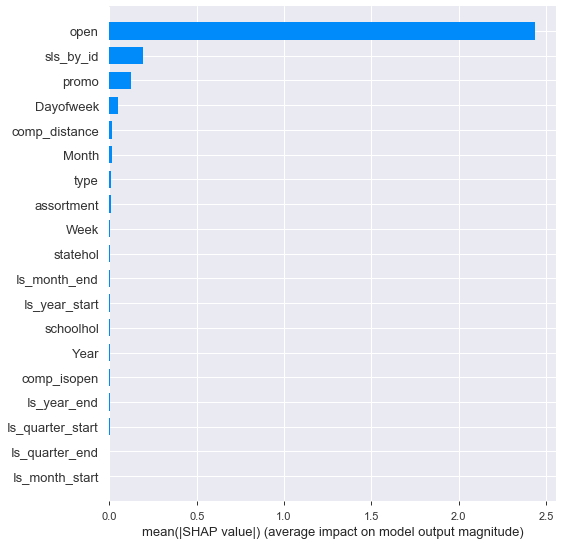

In [17]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(Pool(x2_tr, y_tr, cat_features=df2_tr.select_dtypes(include = ['object', 'bool']).columns))
shap.summary_plot(shap_values, x2_tr, plot_type="bar", max_display=20)

In [18]:
x2_tr, x2_val = pd.get_dummies(x2_tr, drop_first=True), pd.get_dummies(x2_val, drop_first=True)

reg.fit(x2_tr, y_tr)
print_scores(reg, x2_tr, y_tr, x2_val, y_val, 'Reg')

rf.fit(x2_tr, y_tr)
print_scores(rf, x2_tr, y_tr, x2_val, y_val, 'RF')

lgbm.fit(x2_tr, y_tr, eval_set=(x2_val, y_val), early_stopping_rounds=20, verbose=False)
print_scores(lgbm, x2_tr, y_tr, x2_val, y_val, 'LGBM')

Reg: R^2 = 0.994, RMSPE = 0.259, RMSPE validation = 0.266
RF: R^2 = 0.999, RMSPE = 0.102, RMSPE validation = 0.162
LGBM: R^2 = 0.998, RMSPE = 0.132, RMSPE validation = 0.171


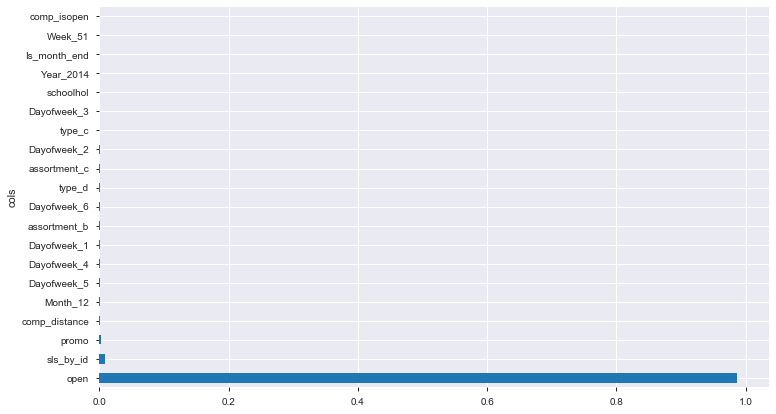

In [19]:
fi = rf_feat_importance(rf, x2_tr)
plot_fi(fi[0:20])

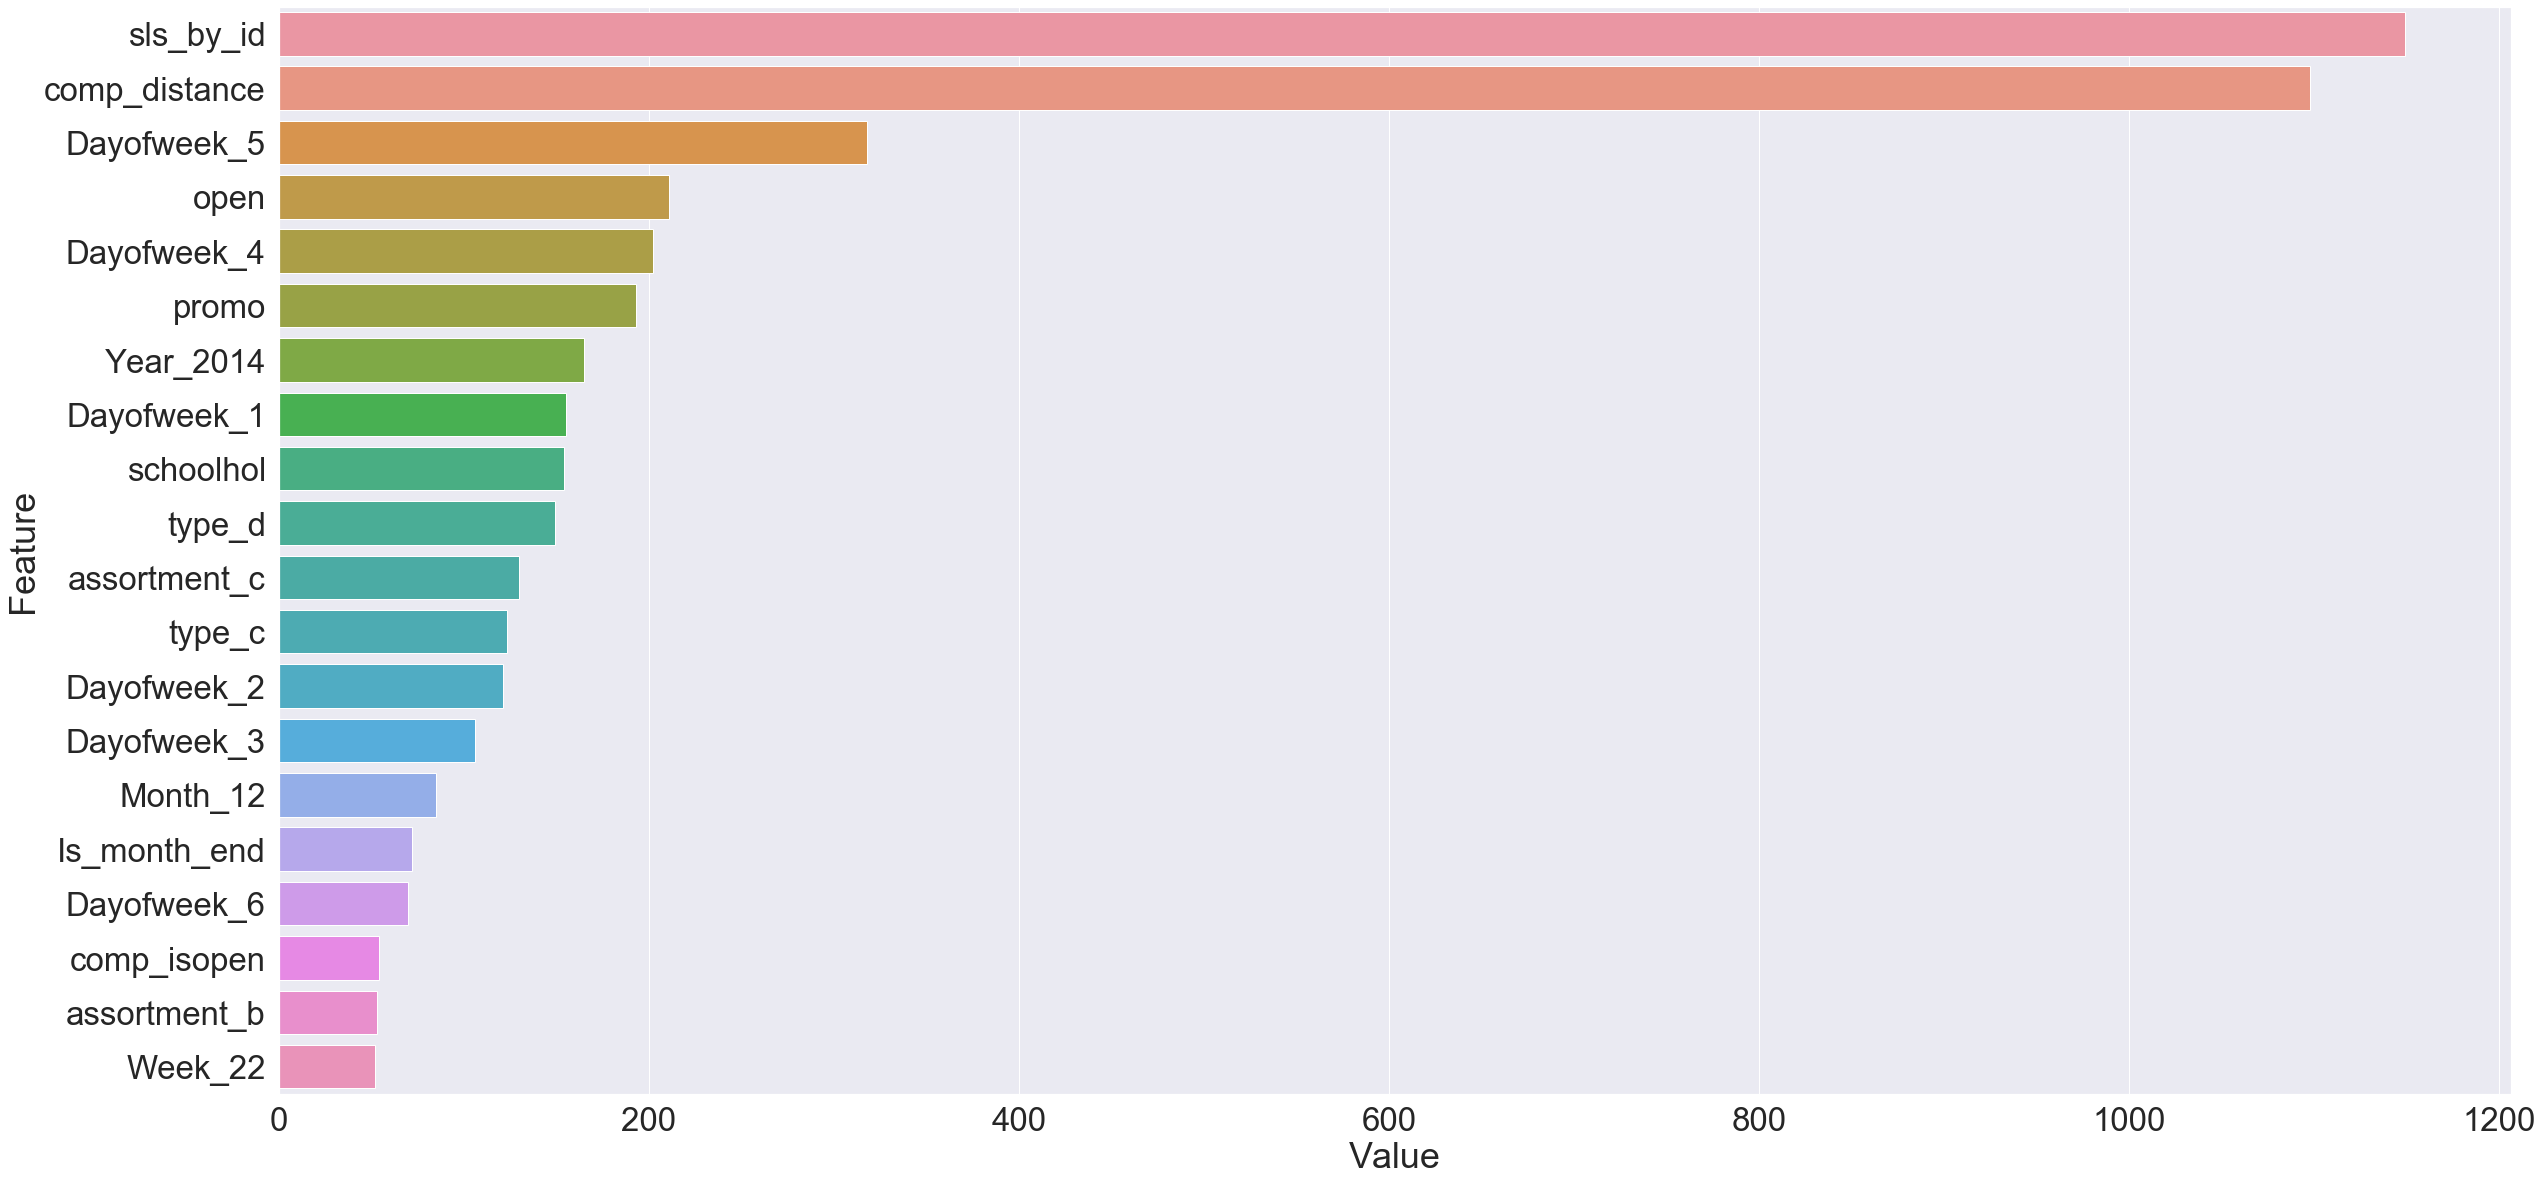

In [20]:
feature_imp = pd.DataFrame({'Value':lgbm.booster_.feature_importance(),'Feature':x2_tr.columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale=3)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:20]);

## Model 3: interaction terms

Based on Shapley value feature importance, we add interaction terms between the some of the most important features as well as poylnomial/logarithmic terms in `comp_distance`, which slightly improves $\mathit{RMSPE}$.

In [21]:
for col in ['open', 'promo', 'schoolhol']:
    df2_tr[col] = df2_tr[col].apply(lambda x:str(x))
    df2_val[col] = df2_val[col].apply(lambda x:str(x))

In [22]:
df2_tr['comp_distance^2'] = df2_tr['comp_distance'].apply(lambda x: x**2)
df2_tr['comp_distance_log'] = df2_tr['comp_distance'].apply(lambda x: np.log(x))

df2_val['comp_distance^2'] = df2_val['comp_distance'].apply(lambda x: x**2)
df2_val['comp_distance_log'] = df2_val['comp_distance'].apply(lambda x: np.log(x))

In [23]:
for col1, col2 in zip(['type', 'type', 'open', 'open', 'promo', 'promo'], ['assortment', 'Dayofweek', 'Dayofweek', 'promo', 'Dayofweek', 'type']):
    df2_tr[col1+'*'+col2] = df2_tr[col1] + df2_tr[col2]
    df2_val[col1+'*'+col2] = df2_val[col1] + df2_val[col2]

x2_tr, x2_val = df2_tr.drop(['sls'], axis=1), df2_val.drop(['sls'], axis=1)

cat.fit(x2_tr, y_tr, cat_features=df2_tr.select_dtypes(include = ['object', 'bool']).columns, eval_set=(x2_val, y_val))
print_scores(cat, x2_tr, y_tr, x2_val, y_val, 'CatBoost')


CatBoost: R^2 = 0.997, RMSPE = 0.19, RMSPE validation = 0.2


In [24]:
x2_tr, x2_val = pd.get_dummies(x2_tr, drop_first=True), pd.get_dummies(x2_val, drop_first=True)

reg.fit(x2_tr, y_tr)
print_scores(reg, x2_tr, y_tr, x2_val, y_val, 'Reg')

rf.fit(x2_tr, y_tr)
print_scores(rf, x2_tr, y_tr, x2_val, y_val, 'RF')

lgbm.fit(x2_tr, y_tr, eval_set=(x2_val, y_val), early_stopping_rounds=20, verbose=False)
print_scores(lgbm, x2_tr, y_tr, x2_val, y_val, 'LGBM')

Reg: R^2 = 0.995, RMSPE = 0.244, RMSPE validation = 0.255
RF: R^2 = 0.999, RMSPE = 0.101, RMSPE validation = 0.154
LGBM: R^2 = 0.998, RMSPE = 0.129, RMSPE validation = 0.166


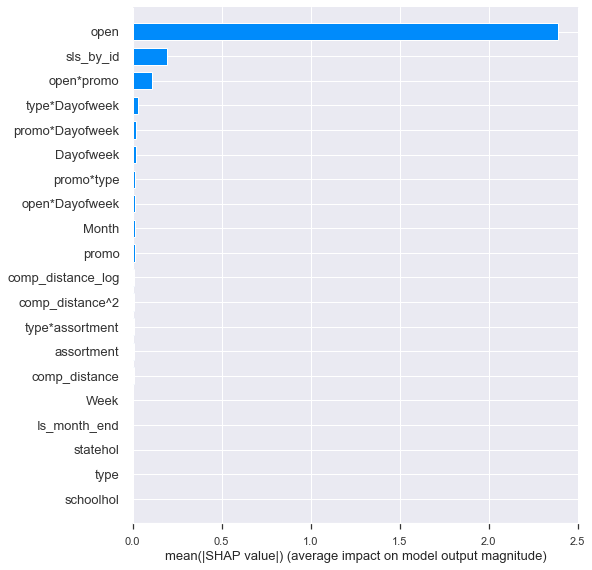

In [28]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(Pool(x2_tr, y_tr, cat_features=x2_tr.select_dtypes(include = ['object', 'bool']).columns))
shap.summary_plot(shap_values, x2_tr, plot_type="bar", max_display=20)

## Model 4: using previous sales data

We now add features representing sales at the given store in the past: `sls_shift_8w`, `sls_shift_2m`, and `sls_shift_1y` (8 weeks, 2 months, and 1 year ago, respectively). The best model is `LightGBM`, with $\mathit{RMSPE} \approx 0.157$. 

In [29]:
df4 = df.sort_values(by = ['id', 'date'], ascending = False)
df4['sls_shift_8w'] = df4['sls'].shift(-56).ffill()
df4['sls_shift_2m'] = df4['sls'].shift(-61).ffill()
df4['sls_shift_1y'] = df4['sls'].shift(-365).ffill()

for col in ['open', 'promo', 'schoolhol']:
    df4[col] = df4[col].apply(lambda x:str(x))

for col1, col2 in zip(['type', 'open', 'open', 'promo', 'promo'], ['Dayofweek', 'Dayofweek', 'promo', 'Dayofweek', 'type']):
    df4[col1+'*'+col2] = df4[col1] + df4[col2]

df4['comp_distance_log'] = df4['comp_distance'].apply(lambda x: np.log(x))

df4 = df4.sort_values(by = ['date'], ascending = False)
df4 = df4.drop(['day', 'cus', 'Elapsed', 'Dayofyear', 'Day'], axis = 1).set_index('id')

df4_val, df4_tr = split_vals(df4, sum(df4.date > date_cutoff))
df4_tr = pd.merge(df4_tr, df4_tr.groupby('id').agg(sls_by_id = ('sls', 'mean')), on='id', how = 'left')
df4_val = pd.merge(df4_val, df4_tr.groupby('id').agg(sls_by_id = ('sls', 'mean')), on='id', how = 'left')

x4_tr, x4_val = df4_tr.drop(['sls', 'date'], axis=1), df4_val.drop(['sls', 'date'], axis=1)
y4_tr, y4_val= df4_tr['sls'], df4_val['sls']

cat.fit(x4_tr, y4_tr, cat_features=x4_tr.select_dtypes(include = ['object', 'bool']).columns, eval_set=(x4_val, y4_val))
print_scores(cat, x4_tr, y4_tr, x4_val, y4_val, 'CatBoost')

CatBoost: R^2 = 0.997, RMSPE = 0.181, RMSPE validation = 0.185


In [32]:
x4_tr, x4_val = pd.get_dummies(x4_tr, drop_first=True), pd.get_dummies(x4_val, drop_first=True)

reg.fit(x4_tr, y4_tr)
print_scores(reg, x4_tr, y4_tr, x4_val, y4_val, 'Reg')

rf.fit(x4_tr, y4_tr)
print_scores(rf, x4_tr, y4_tr, x4_val, y4_val, 'RF')

lgbm.fit(x4_tr, y4_tr, eval_set=(x4_val, y4_val), early_stopping_rounds=20, verbose=False)
print_scores(lgbm, x4_tr, y4_tr, x4_val, y4_val, 'LGBM')

Reg: R^2 = 0.995, RMSPE = 0.243, RMSPE validation = 0.255
RF: R^2 = 0.999, RMSPE = 0.093, RMSPE validation = 0.158
LGBM: R^2 = 0.999, RMSPE = 0.123, RMSPE validation = 0.157


## Model 5: hyperparameter optimization

To optimize hyperparameters for the `LightGBM` model we use a grid search with a 3-fold time-series cross-validation. 

In [34]:
tscv = TimeSeriesSplit(n_splits=3)

gbm_param = {'learn_rate': [0.002, 0.01, 0.05], 'min_samples_leaf': [10, 20, 60],
             'num_leaves': [30, 70, 170], 'feature_fraction': [0.2, 0.6, 1]}

gd_sr = GridSearchCV(estimator=lgbm, param_grid=gbm_param, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)
gd_sr.fit(x4_tr, y4_tr)

print(gd_sr.best_params_)

{'feature_fraction': 1, 'learn_rate': 0.002, 'min_samples_leaf': 10, 'num_leaves': 170}


In [35]:
lgbm = lgb.LGBMRegressor(n_estimators=200, eval_metric = 'rmse', feature_fraction= 1, learn_rate= 0.002, min_samples_leaf = 10, num_leaves =170)

In [36]:
lgbm.fit(x4_tr, y4_tr, eval_set=(x4_val, y4_val), early_stopping_rounds=20, verbose=False)
print_scores(lgbm, x4_tr, y4_tr, x4_val, y4_val, 'LGBM')

LGBM: R^2 = 0.999, RMSPE = 0.097, RMSPE validation = 0.152
